In [1]:
from jarvis.utils.general import gpus
gpus.find_all()

{0: {'alloc': 0, 'total': 11178, 'percentage': 0.0},
 1: {'alloc': 0, 'total': 11178, 'percentage': 0.0},
 2: {'alloc': 10913, 'total': 11178, 'percentage': 0.9762927178386116},
 3: {'alloc': 0, 'total': 11178, 'percentage': 0.0}}

In [2]:
gpus.find_available()

{0: {'alloc': 0, 'total': 11178, 'percentage': 0.0},
 1: {'alloc': 0, 'total': 11178, 'percentage': 0.0},
 3: {'alloc': 0, 'total': 11178, 'percentage': 0.0}}

In [6]:
gpus.autoselect()

[ 2022-07-02 15:11:09 ] CUDA_VISIBLE_DEVICES automatically set to: 0           


In [7]:
import numpy as np
from jarvis.train import datasets
from jarvis.utils.display import imshow
from tensorflow.keras import Input
from jarvis.train.client import Client

from IPython.display import clear_output
import matplotlib.pyplot as plt
import tensorflow as tf

In [8]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [9]:
def show_mri(mri):
    for i in range(mri.shape[0]):
        clear_output(wait=True)
        plt.axis(False)
        plt.imshow(mri[i, :, :, 0], cmap='gray')
        plt.show()

In [10]:
# --- prepare generators
client = Client('/data/raw/miccai_rsna/data/ymls/client-3d.yml')
gen_train, gen_valid = client.create_generators()

In [11]:
# --- Show a sample training set
xs, ys = next(gen_train)
# imshow(xs['t2w'][0][24], radius=1)
ys['lbl'].reshape(4, 1)

array([[0],
       [1],
       [0],
       [0]], dtype=uint8)

In [12]:
flair = xs['fla']
flair.shape

(4, 48, 96, 96, 1)

In [13]:
flair1 = flair[0]

In [14]:
flair1.shape

(48, 96, 96, 1)

In [15]:
np.min(flair1)

-0.9031360994148053

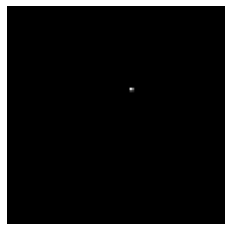

In [16]:
show_mri(flair[1])

In [17]:
ys

{'lbl': array([[[[[0]]]],
 
 
 
        [[[[1]]]],
 
 
 
        [[[[0]]]],
 
 
 
        [[[[0]]]]], dtype=uint8)}

In [18]:
ys['lbl'][:, 0, 0, 0]

array([[0],
       [1],
       [0],
       [0]], dtype=uint8)

In [19]:
xs.keys()

dict_keys(['t2w', 't1w', 't1wce', 'fla', 'lbl'])

In [20]:
# --- Print keys 
for key, arr in xs.items():
    print('xs key: {} | shape = {}'.format(key.ljust(8), arr.shape))

xs key: t2w      | shape = (4, 48, 96, 96, 1)
xs key: t1w      | shape = (4, 48, 96, 96, 1)
xs key: t1wce    | shape = (4, 48, 96, 96, 1)
xs key: fla      | shape = (4, 48, 96, 96, 1)
xs key: lbl      | shape = (4, 1, 1, 1, 1)


In [21]:
# --- Create model inputs
inputs = client.get_inputs(Input)

In [22]:
inputs

{'t2w': <KerasTensor: shape=(None, 48, 96, 96, 1) dtype=float32 (created by layer 't2w')>,
 't1w': <KerasTensor: shape=(None, 48, 96, 96, 1) dtype=float32 (created by layer 't1w')>,
 't1wce': <KerasTensor: shape=(None, 48, 96, 96, 1) dtype=float32 (created by layer 't1wce')>,
 'fla': <KerasTensor: shape=(None, 48, 96, 96, 1) dtype=float32 (created by layer 'fla')>,
 'lbl': <KerasTensor: shape=(None, 1, 1, 1, 1) dtype=uint8 (created by layer 'lbl')>}

In [23]:
from ResNet10.ResNet10_3D import build_resnet
base_model = build_resnet()

In [24]:
base_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2), loss='binary_crossentropy', metrics=['acc'])

In [25]:
from tensorflow.keras.losses import BinaryCrossentropy

In [26]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-2)
bce = BinaryCrossentropy()
# @tf.function
def train_step(x, y):
#     print(y.shape)
    loss = base_model.train_on_batch(x, y)
#     with tf.GradientTape() as tape:
# #         print('beginning training...')
#         y_hat = base_model(x, training=True)
# #         print(y_hat.shape)
# #         print('done training...')
#         loss = bce(y, y_hat)
#     grads = tape.gradient(loss, base_model.trainable_variables)
#     opt.apply_gradients(zip(grads, base_model.trainable_variables))
    return loss

In [27]:
annoying_case = None
annoying_case_unproc = None

In [28]:
def train(train_dataset, n_epochs=1, max_steps_per_epoch=None):
    global annoying_case, annoying_case_unproc
    for epoch in range(n_epochs):
        for i, batch in enumerate(train_dataset):
            xs, ys = batch
            inp = np.empty((4, 48, 96, 96, 4))
            inp[:, :, :, :, 0] = xs['t2w'][:, :, :, 0]
            inp[:, :, :, :, 1] = xs['t1w'][:, :, :, 0]
            inp[:, :, :, :, 2] = xs['t1wce'][:, :, :, 0]
            inp[:, :, :, :, 3] = xs['fla'][:, :, :, 0]
            inp = tf.image.per_image_standardization(inp)
#             print(xs['fla'].shape)
#             fla = xs['fla']
            x_prep = inp # (inp-np.min(inp))/(np.max(inp)-np.min(inp))
            if max_steps_per_epoch is not None:
                if i == max_steps_per_epoch:
                    break
#             adversarial = (epoch >= 1)
            if(np.isnan(x_prep).any()):
                continue
            l1 = base_model.train_on_batch(x_prep, ys['lbl'].reshape(4, 1))
#             train_step(x_prep, ys['lbl'].reshape(4, 1))#[:, 0, 0, 0])
#             del batch
            clear_output(wait=True)
            if np.isnan(np.max(x_prep)) or np.isnan(np.min(x_prep)):
                annoying_case = x_prep
                annoying_case_unproc = fla
#             show_mri(x_prep[0])
            print("Epoch {}/{}".format(epoch + 1, n_epochs))
            print(f'Step {i+1}')
#             print(f'MRI Shape: {x_prep.shape}')
#             print(f'Max Flair: {np.max(x_prep)}')
#             print(f'Min Flair: {np.min(x_prep)}')
            print(f'Loss: {l1}')
            

In [29]:
print(tf.test.gpu_device_name())

/device:GPU:0


In [30]:
# --- prepare generators
client = Client('/data/raw/miccai_rsna/data/ymls/client-3d.yml')
gen_train, gen_valid = client.create_generators()
train(gen_train, max_steps_per_epoch=100, n_epochs=1)

Epoch 1/1
Step 100
Loss: [1.8463215827941895, 0.25]


In [31]:
NUM_VAL_SCANS = 100

In [35]:
preds = []
labels = []
for i, batch in enumerate(gen_train):
    xs, ys = batch
    inp = np.empty((4, 48, 96, 96, 4))
    inp[:, :, :, :, 0] = xs['t2w'][:, :, :, 0]
    inp[:, :, :, :, 1] = xs['t1w'][:, :, :, 0]
    inp[:, :, :, :, 2] = xs['t1wce'][:, :, :, 0]
    inp[:, :, :, :, 3] = xs['fla'][:, :, :, 0]
    inp = tf.image.per_image_standardization(inp)
    pred = base_model.predict(inp)
    y = ys['lbl']
    labels.append(y.reshape(4, 1))
    preds.append(pred)
    if i == NUM_VAL_SCANS:
        break

/home/caidm/jarvis/jarvis-core/jarvis/train/client/client.py:983: RuntimeWarning: invalid value encountered in true_divide
  arr_ = arr / scale


In [30]:
preds = np.array(preds).reshape(-1,)
labels = np.array(labels).reshape(-1,)

In [31]:
preds

array([1.        , 1.        , 0.99984443, 0.99692   , 1.        ,
       0.99999964, 0.9999058 , 1.        , 0.9999478 , 0.9988187 ,
       0.9999738 , 0.9998178 , 1.        , 0.992762  , 1.        ,
       0.9995172 , 0.99947137, 0.999708  , 0.9988784 , 0.99866915,
       0.9997018 , 1.        , 0.99537957, 0.99925643, 0.9907374 ,
       0.9983254 , 0.9959447 , 1.        , 0.99891305, 1.        ,
       0.9997291 , 0.99996686, 1.        , 0.9999851 , 1.        ,
       0.99998605, 0.9993672 , 0.99997056, 1.        , 0.9999448 ,
       0.9983146 , 0.9940796 , 0.9998148 , 0.9995764 , 1.        ,
       1.        , 1.        , 1.        , 0.9926702 , 0.999997  ,
       1.        , 1.        , 0.99806625, 0.99150616, 1.        ,
       0.9928369 , 1.        , 0.99765956, 1.        , 1.        ,
       0.99942076, 0.99999976, 0.9999906 , 0.99964726, 0.999673  ,
       0.99977416, 0.983489  , 0.9999875 , 0.999073  , 1.        ,
       1.        , 0.99994147, 0.9997733 , 0.9996145 , 0.99913

In [32]:
disc_preds = np.zeros(preds.shape)
disc_preds[preds > 0.5] = 1

In [33]:
from sklearn.metrics import accuracy_score, roc_auc_score

In [34]:
acc = accuracy_score(labels, disc_preds)
auc = roc_auc_score(labels, preds)
print(f'Validated on {NUM_VAL_SCANS} scans...')
print(f'Accuracy: {acc}')
print(f'AUC: {auc}')

Validated on 200 scans...
Accuracy: 0.48756218905472637
AUC: 0.4542426193778482
